In [2]:
import pandas as pd
from datetime import timedelta
import numpy as np


### 1 : Load the Dataset

In [3]:


file_path = "events.csv"
df = pd.read_csv(file_path)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


### 2: Data Cleaning and Preprocessing

In [5]:
print(df.isnull().sum())

event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64


In [6]:
missing_category_code = df[df['category_code'] == 'Unknown']['product_id'].value_counts()
print("\nProducts with missing category_code:")
print(missing_category_code.head())



Products with missing category_code:
Series([], Name: product_id, dtype: int64)


In [7]:
missing_brand = df[df['brand'] == 'Unknown']['category_code'].value_counts()
print("\nCategories with missing brand:")
print(missing_brand.head())


Categories with missing brand:
Series([], Name: category_code, dtype: int64)


In [8]:
df['category_code'] = df['category_code'].fillna('Unknown')

In [9]:
df = df.dropna(subset=['user_session'])

In [10]:
df['brand'] = df['brand'].fillna('Unknown')

In [11]:
df.isna().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [12]:
df['event_time'].head()

0    2020-09-24 11:57:06 UTC
1    2020-09-24 11:57:26 UTC
2    2020-09-24 11:57:27 UTC
3    2020-09-24 11:57:33 UTC
4    2020-09-24 11:57:36 UTC
Name: event_time, dtype: object

In [13]:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)
df['event_time'].head()

0   2020-09-24 11:57:06+00:00
1   2020-09-24 11:57:26+00:00
2   2020-09-24 11:57:27+00:00
3   2020-09-24 11:57:33+00:00
4   2020-09-24 11:57:36+00:00
Name: event_time, dtype: datetime64[ns, UTC]

In [14]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [15]:
df = df.drop_duplicates()

In [16]:
df.shape

(884312, 9)

### 3: EDA

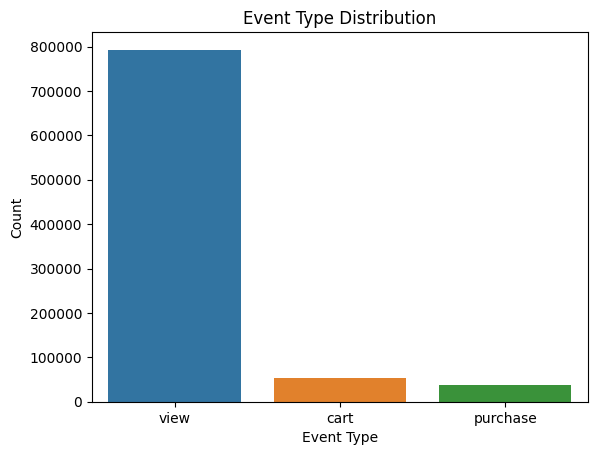

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

event_counts = df['event_type'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()


In [18]:
user_summary = df.groupby('user_id').agg({
    'event_type': 'count',
    'price': ['sum', 'mean'],
    'user_session': 'nunique'
}).reset_index()

user_summary.columns = ['user_id', 'event_count', 'total_spent', 'avg_spent', 'unique_sessions']
print(user_summary.head())


               user_id  event_count  total_spent   avg_spent  unique_sessions
0  1515915625353226922            1        76.48   76.480000                1
1  1515915625353230067            1        28.98   28.980000                1
2  1515915625353230683           13       814.93   62.686923                4
3  1515915625353230922            1       274.40  274.400000                1
4  1515915625353234047           36      5481.90  152.275000                1


### 4: Churn

In [19]:

last_event_date = df['event_time'].max()
churn_threshold_date = last_event_date - timedelta(days=30)

user_last_activity = df.groupby('user_id')['event_time'].max().reset_index()
user_last_activity['churned'] = user_last_activity['event_time'] < churn_threshold_date

print(user_last_activity.head())

               user_id                event_time  churned
0  1515915625353226922 2020-10-29 11:28:35+00:00     True
1  1515915625353230067 2020-10-06 06:30:32+00:00     True
2  1515915625353230683 2020-12-12 10:33:09+00:00     True
3  1515915625353230922 2020-10-02 08:23:40+00:00     True
4  1515915625353234047 2021-02-18 09:11:44+00:00    False


### 5: Feature Engineering

In [20]:
## -> Recency / frequency / monetary metrics

In [21]:
# 1 : RFM metrics
rfm = df.groupby('user_id').agg({
    'event_time': lambda x: (last_event_date - x.max()).days,
    'user_session': 'nunique',
    'price': 'sum'
}).reset_index()

rfm.columns = ['user_id', 'recency', 'frequency', 'monetary']
print(rfm.head())


               user_id  recency  frequency  monetary
0  1515915625353226922      122          1     76.48
1  1515915625353230067      145          1     28.98
2  1515915625353230683       78          4    814.93
3  1515915625353230922      149          1    274.40
4  1515915625353234047       10          1   5481.90


In [22]:
# view to cart and cart to purchase ratios
behavior_ratios = df.pivot_table(
    index='user_id',
    columns='event_type',
    values='event_time',
    aggfunc='count'
).fillna(0)


behavior_ratios['view_to_cart_ratio'] = np.where(
    behavior_ratios['view'] > 0,
    behavior_ratios['cart'] / behavior_ratios['view'],
    0 
)

behavior_ratios['cart_to_purchase_ratio'] = np.where(
    behavior_ratios['cart'] > 0,
    behavior_ratios['purchase'] / behavior_ratios['cart'],
    0  
)



In [23]:
behavior_ratios.head()

event_type,cart,purchase,view,view_to_cart_ratio,cart_to_purchase_ratio
user_id,,,,,
1515915625353226922,0.0,0.0,1.0,0.0,0.0
1515915625353230067,0.0,0.0,1.0,0.0,0.0
1515915625353230683,0.0,0.0,13.0,0.0,0.0
1515915625353230922,0.0,0.0,1.0,0.0,0.0
1515915625353234047,0.0,0.0,36.0,0.0,0.0


### 6 : Model Traning 

In [24]:
features = rfm.merge(behavior_ratios, on='user_id').merge(user_last_activity[['user_id', 'churned']], on='user_id')
features

,user_id,recency,frequency,monetary,cart,purchase,view,view_to_cart_ratio,cart_to_purchase_ratio,churned
0,1515915625353226922,122,1,76.48,0.0,0.0,1.0,0.0,0.0,True
1,1515915625353230067,145,1,28.98,0.0,0.0,1.0,0.0,0.0,True
2,1515915625353230683,78,4,814.93,0.0,0.0,13.0,0.0,0.0,True
3,1515915625353230922,149,1,274.40,0.0,0.0,1.0,0.0,0.0,True
4,1515915625353234047,10,1,5481.90,0.0,0.0,36.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...
407232,1515915625611023671,0,1,32.22,0.0,0.0,1.0,0.0,0.0,False
407233,1515915625611023730,0,1,219.94,0.0,0.0,1.0,0.0,0.0,False
407234,1515915625611024014,0,1,80.03,0.0,0.0,1.0,0.0,0.0,False
407235,1515915625611024020,0,1,64.92,0.0,0.0,1.0,0.0,0.0,False


In [25]:
X = features.drop(columns=['user_id', 'churned'])
y = features['churned']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score


In [28]:
param_grid = {
    'n_estimators': [100, 200, 300],      
    'min_samples_split': [2, 5],   
    'min_samples_leaf': [1, 2],      
    'max_features': ['sqrt', 'log2'],   
    'bootstrap': [True, False]          
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  
    scoring='roc_auc',  
    verbose=2,          
    n_jobs=-1           
)


In [29]:
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best AUC Score: 1.0


In [30]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     23908
        True       1.00      1.00      1.00     98264

    accuracy                           1.00    122172
   macro avg       1.00      1.00      1.00    122172
weighted avg       1.00      1.00      1.00    122172

AUC: 1.0


### 7: Interpretability and Insights

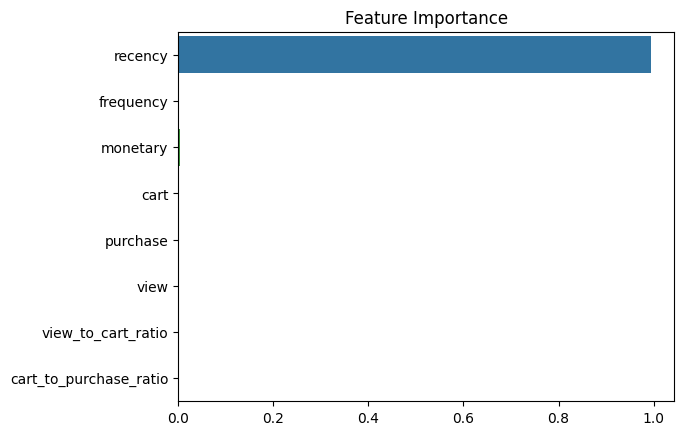

In [36]:
importances = best_rf.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.show()
